# Chapter 8: Play

This notebook contains an implementation of training an agent for the [OpenAI Gym `CarRacing-v0` environment](https://gym.openai.com/envs/CarRacing-v0/).

## World Model

This notebook will be using the [World Model architecture](https://arxiv.org/abs/1803.10122) to train a model for the `CarRacing-v0` environment using the model's own generated "dream" of the environment. The code is based on the implementation in [this repository](https://github.com/AppliedDataSciencePartners/WorldModels).

The model is broken up into 3 main components: a variational autoencoder (VAE), a recurrent neural network with a mixture density network (MDN-RNN), and finally a controller.

### The Variational Autoencoder

The VAE will be trained first to encode the observations of different game states into a into a normally distributed, lower-dimensional latent space.

### The MDN-RNN

The MDN-RNN is trained after the VAE. Its goal is to predict the distribution of the next possible state in the latent space and the future reward at that state using the VAE's encoding, the most recent action, and the current reward as input. It consists of an LSTM network and a mixture-density network (MDN) output layer allows the next state could be sampled from numerous different normal distributions.

### The Controller

The controller is a densely connected neural network whose input is the concatenation of the output of the VAE and the hidden state of the LSTM network. The network's 3 output neurons represent the 3 possible actions the agent can take (steer, accelerate, brake).

## Setup

In [ ]:
!pip3 install Box2D gym

In [3]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [ ]:
!pip3 install pyvirtualdisplay

In [ ]:
!pip3 install pyglet --upgrade

In [ ]:
!pip3 install cma --upgrade

In [ ]:
import os
from google.colab import drive

drive.mount('/content/gdrive/')
base_dir = '/content/gdrive/My Drive/gdl_models/world/'
rollout_dir = os.path.join(base_dir, 'rollout/')
vae_weights_dir = os.path.join(base_dir, 'vae/')
series_dir = os.path.join(base_dir, 'series/')
rnn_weights_dir = os.path.join(base_dir, 'rnn/')
controller_weights_dir = os.path.join(base_dir, 'controller/')

In [3]:
from pyvirtualdisplay import Display

display = Display(visible=0, size=(300, 300))
display.start()

In [4]:
Z_DIM = 32
ACTION_DIM = 3
GAUSSIAN_MIXTURES = 5
RNN_HIDDEN_UNITS = 256
STARTUP_FRAMES = 20

In [5]:
%matplotlib inline
import cma
import gym
from gym.spaces.box import Box
from gym.utils import seeding
import json
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import numpy as np
import pickle
import random
import time
from IPython.display import HTML

%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization,
                                     LeakyReLU, Dropout, Flatten, Dense,
                                     Lambda, Reshape, Conv2DTranspose,
                                     Activation, LSTM)
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

TensorFlow 1.x selected.


Below are some utility functions used in several parts of the notebook. Feel free to skip past them if you're reading this for the first time.

In [6]:
def scale_observation(obs):
  """Scale observation pixel values to [0, 1]."""
  return obs.astype('float32') / 255.0


def update_scene(num, frames, patch):
  """Update the animation scene after a single frame."""
  patch.set_data(frames[num])
  return patch


def plot_animation(frames, repeat=False, interval=40):
  """Utility function for """
  plt.close()
  fig = plt.figure()
  patch = plt.imshow(frames[0])
  plt.axis('off')
  anim = animation.FuncAnimation(fig, update_scene, fargs=(frames, patch),
                                 frames=len(frames), repeat=repeat,
                                 interval=interval)
  return HTML(anim.to_html5_video())


def get_pi_idx(x, pdf):
  """Sample from the different normal distributions output by the MDN-RNN."""
  n = pdf.size
  acc = 0
  for i in range(0, n):
    acc += pdf[i]
    if acc >= x:
      return i
  random_value = np.random.randint(n)
  return random_value


def get_mixture_coeff_np(z_pred):
  """Separate the predicted 480 dimensional state into 3 variables."""
  log_pi, mu, log_sigma = np.split(z_pred, 3, 1)
  # Axis 1 is the mixture coefficient.
  log_pi = log_pi - np.log(np.sum(np.exp(log_pi), axis=1, keepdims=True))
  return log_pi, mu, log_sigma


def sample_mu_log_sigma(log_pi, mu, log_sigma):
  """Sample the mu and log_sigma from the MDN output."""
  chosen_mu = np.zeros(shape=Z_DIM)
  chosen_log_sigma = np.zeros(shape=Z_DIM)

  pi = np.exp(np.copy(log_pi))
  pi /= pi.sum(axis=1).reshape(Z_DIM, 1)

  for j in range(Z_DIM):
    idx = get_pi_idx(np.random.rand(), pi[j])
    chosen_mu[j] = mu[j, idx]
    chosen_log_sigma[j] = log_sigma[j, idx]
  
  return chosen_mu, chosen_log_sigma


def adjust_reward(reward):
  """Returns 1 if the reward is positive, 0 otherwise."""
  return float(reward > 0)

## Generating the Rollout Data for the VAE

Below is code that will generate the _rollout data_, data made up of observations of an agent acting randomly in the environment.

In [13]:
def collect_rollout_data(total_episodes=1000, timesteps=300,
                         action_refresh_rate=20):
  """Collect the rollout data for training the VAE."""
  env = gym.make('CarRacing-v0')

  for s in range(total_episodes):
    print('Running episode:\t', s)
    episode_id = str(int(time.time()))
    filename = os.path.join(rollout_dir, episode_id + '.npz')
    obs = env.reset()
    env.render()

    observations = []
    actions = []
    rewards = []
    done_sequence = []

    reward = -0.1
    done = False

    for t in range(timesteps):
      if t % action_refresh_rate == 0:
        action = env.action_space.sample()
      observations.append(scale_observation(obs))
      actions.append(action)
      rewards.append(reward)
      done_sequence.append(done)

      obs, reward, done, info = env.step(action)
      env.render()

    np.savez_compressed(filename, obs=observations, action=actions,
                        reward=rewards, done=done_sequence)
  env.close()

In [ ]:
collect_rollout_data()

## Implementing and Training the VAE

Below we will implement the variational autoencoder (VAE) this model will use to encode the game state into a normal distribution in a lower-dimensional latent space.

In [7]:
def sampling(args):
  """Sample an encoding from the learned distribution."""
  mu, log_var = args
  return mu + K.exp(log_var / 2) * K.random_normal(shape=K.shape(mu))


def step_decay_schedule(initial_lr, decay_factor=0.5, step_size=1):
  """Create a LearningRateScheduler callback to decay the learning rate during training."""
  def schedule(epoch):
    return initial_lr * (decay_factor ** np.floor(epoch/step_size))
  return LearningRateScheduler(schedule)


class VAE():
  """Implements a varational autoencoder (VAE) using Keras."""

  def __init__(self, input_shape, encoder_conv_filters,
               encoder_conv_kernel_size, encoder_conv_strides,
               encoder_activations, decoder_conv_filters,
               decoder_conv_kernel_size, decoder_conv_strides,
               decoder_activations, z_dim, use_batch_normalization=False,
               use_dropout=False, dropout_rate=0.25):
    self.input_shape = input_shape
    encoder_input = Input(shape=input_shape, name='encoder_input')
    x = encoder_input
    for i in range(len(encoder_conv_kernel_size)):
      x = Conv2D(filters=encoder_conv_filters[i],
                 kernel_size=encoder_conv_kernel_size[i],
                 strides=encoder_conv_strides[i], padding='same',
                 name='encoder_conv_{}'.format(i + 1))(x)
      if use_batch_normalization:
        x = BatchNormalization()(x)
      if encoder_activations[i] == 'lrelu':
        x = LeakyReLU()(x)
      else:
        x = Activation(encoder_activations[i])(x)
      if use_dropout:
        x = Dropout(rate=dropout_rate)(x)
    shape_before_flattening = K.int_shape(x)[1:]
    x = Flatten()(x)
    self.z_dim = z_dim
    self.mu = Dense(z_dim, name='mu')(x)
    self.log_var = Dense(z_dim, name='log_var')(x)
    self.encoder_mu_log_var = Model(encoder_input, (self.mu, self.log_var))
    encoder_output = Lambda(sampling,
                            name='encoder_output')([self.mu, self.log_var])
    self.encoder = Model(encoder_input, encoder_output)

    decoder_input = Input(shape=(z_dim,), name='decoder_input')
    x = Dense(np.prod(shape_before_flattening))(decoder_input)
    x = Reshape(shape_before_flattening)(x)
    for i in range(len(decoder_conv_kernel_size)):
      x = Conv2DTranspose(filters=decoder_conv_filters[i],
                          kernel_size=decoder_conv_kernel_size[i],
                          strides=decoder_conv_strides[i], padding='same',
                          name='decoder_conv_t_{}'.format(i + 1))(x)
      if i < len(decoder_conv_kernel_size) - 1:
        if use_batch_normalization:
          x = BatchNormalization()(x)
      if decoder_activations[i] == 'lrelu':
        x = LeakyReLU()(x)
      else:
        x = Activation(decoder_activations[i])(x)
      if use_dropout and i < len(decoder_conv_kernel_size) - 1:
          x = Dropout(rate=dropout_rate)(x)
    decoder_output = x
    self.decoder = Model(decoder_input, decoder_output)
    self.model = Model(encoder_input, self.decoder(encoder_output))
    self.compiled = False
    self.learning_rate = None

  def compile(self, learning_rate, r_loss_factor):
    """Compile the model."""
    self.learning_rate = learning_rate
    if self.compiled:
      return
    opt = Adam(lr=learning_rate)

    def mse(y_act, y_pred):
      return r_loss_factor * K.mean(K.square(y_act - y_pred), axis=(1, 2, 3))

    def kl_divergence(y_act, y_pred):
      return -0.5 * K.sum(
        1 + self.log_var - K.square(self.mu) - K.exp(self.log_var), axis=1)

    def loss(y_act, y_pred):
      return mse(y_act, y_pred) + kl_divergence(y_act, y_pred)
    
    self.model.compile(opt, loss=loss, metrics=[mse, kl_divergence],
                       experimental_run_tf_function=False)
    self.compiled = True

  def fit_with_generator(self, data_flow, epochs, steps_per_epoch,
                         checkpoint_path=None, lr_decay=1, initial_epoch=0,):
    if not self.compiled:
      raise Exception('Model not compiled')
    if initial_epoch > 0:
      self.load(checkpoint_path + 'weights_{:03d}.hdf5'.format(initial_epoch))
    lr_sched = step_decay_schedule(initial_lr=self.learning_rate,
                                   decay_factor=lr_decay, step_size=1)
    callbacks = [lr_sched]
    if checkpoint_path:
      callbacks.append(ModelCheckpoint(
          filepath=checkpoint_path + 'weights.hdf5', verbose=1,
          save_weights_only=True))
      callbacks.append(ModelCheckpoint(
          filepath=checkpoint_path + 'weights_{epoch:03d}.hdf5', verbose=1,
          save_weights_only=True))
    self.model.fit_generator(data_flow, epochs=epochs, shuffle=True,
                             callbacks=callbacks, initial_epoch=initial_epoch,
                             steps_per_epoch=steps_per_epoch)
    

def build_vae():
  """Return a new instance of the VAE for this task."""
  return VAE(input_shape=(96, 96, 3),
             encoder_conv_filters=(32, 64, 64, 128),
             encoder_conv_kernel_size=(4, 4, 4, 4),
             encoder_conv_strides=(2, 2, 2, 2),
             encoder_activations=('relu', 'relu', 'relu', 'relu'),
             decoder_conv_filters=(64, 64, 32, 3),
             decoder_conv_kernel_size=(5, 5, 6, 6),
             decoder_conv_strides=(2, 2, 2, 2),
             decoder_activations=('relu', 'relu', 'relu', 'sigmoid'),
             z_dim=Z_DIM)

I will initialize the model with mostly the same hyperparameters are the [original code](https://github.com/AppliedDataSciencePartners/WorldModels/blob/master/vae/arch.py), but with some modifications to see how they impact the performance of the overall model.

In [ ]:
LEARNING_RATE = 0.0001

vae = build_vae()
vae.compile(LEARNING_RATE, r_loss_factor=1000)

In [ ]:
vae.model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 48, 48, 32)   1568        encoder_input[0][0]              
__________________________________________________________________________________________________
activation (Activation)         (None, 48, 48, 32)   0           encoder_conv_1[0][0]             
__________________________________________________________________________________________________
encoder_conv_2 (Conv2D)         (None, 24, 24, 64)   32832       activation[0][0]                 
____________________________________________________________________________________________

In [ ]:
BATCH_SIZE = 100
EPOCHS = 10
N_IMGS = 300 * len(os.listdir(rollout_dir))
STEPS_PER_EPOCH = N_IMGS // BATCH_SIZE
N_LOADS_PER_BATCH = 300 // BATCH_SIZE
IMAGE_SIZE = (96, 96)

def vae_training_data():
  """Load the VAE training data."""
  fnames = os.listdir(rollout_dir)
  fnames.sort()
  while True:
    for fname in fnames:
      new_data = np.load(rollout_dir + fname)['obs']
      data = np.zeros((BATCH_SIZE, *IMAGE_SIZE, 3))
      for i in range(N_LOADS_PER_BATCH):
        data[:,:,:,:] = new_data[i * BATCH_SIZE:(i + 1) * BATCH_SIZE, :, :, :]
        yield data, data

In [ ]:
X_train = vae_training_data()

In [ ]:
vae.fit_with_generator(X_train, epochs=EPOCHS,
                       steps_per_epoch=STEPS_PER_EPOCH,
                       checkpoint_path=vae_weights_dir)

### Analyzing the VAE

First we will analyze how the VAE reconstructs images from the training set.

In [ ]:
vae.model.load_weights(vae_weights_dir + 'weights.hdf5')

In [ ]:
fnames = os.listdir(rollout_dir)
fname = os.path.join(rollout_dir, fnames[200])
obs_data = np.load(fname)['obs']
obs_data.shape

(300, 96, 96, 3)

(-0.5, 95.5, 95.5, -0.5)

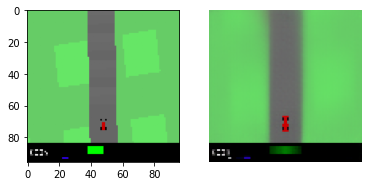

In [ ]:
plt.gca().cla()
 
obs = obs_data[40]
z_decoded = vae.model.predict(np.array([obs]))[0]

plt.subplot(121)
plt.imshow(obs)
plt.subplot(122)
plt.imshow(z_decoded)
plt.axis('off')

In [ ]:
encoded_mu_log_var = vae.encoder_mu_log_var.predict(np.array([obs]))
mu = encoded_mu_log_var[0][0]
log_var = encoded_mu_log_var[1][0]

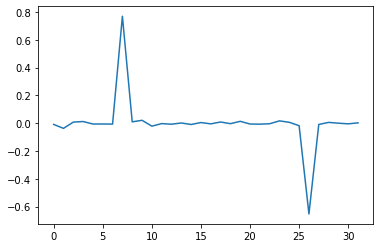

In [ ]:
plt.plot(mu)

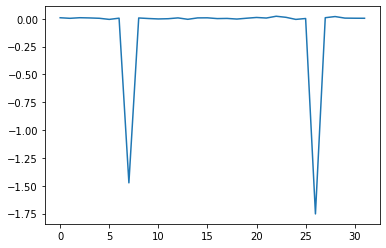

In [ ]:
plt.plot(log_var)

Another way to test the performance of an autonecoder is to decode randomly sampled noise from the latent space.

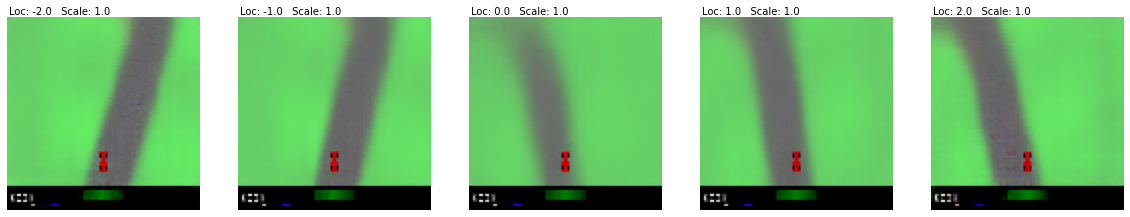

In [ ]:
plt.figure(figsize=(20, 10))

for i in range(5):
  plt.subplot(1, 5, i + 1)
  loc = -2.0 + i
  plt.imshow(
      vae.decoder.predict(np.random.normal(loc, 1.0, size=(1, Z_DIM)))[0])
  plt.axis('off')
  plt.text(0.5, -2.0, 'Loc: {}   Scale: {}'.format(loc, scale))

## Collecting Rollout Data for the MDN-RNN

In [7]:
def collect_rnn_series_data():
  """Collect training data for the MDN-RNN."""
  fnames = os.listdir(rollout_dir)
  fnames.sort()
  initial_mus = []
  initial_log_vars = []
  for fname in fnames:
    episode = np.load(os.path.join(rollout_dir, fname))
    obs = episode['obs']
    action = episode['action']
    reward = episode['reward']
    done = episode['done']

    done = done.astype(int)
    reward = np.where(reward > 0, 0.0, 1.0) * np.where(done == 0, 1, 0)
    
    mu, log_var = vae.encoder_mu_log_var.predict(obs)

    np.savez_compressed(os.path.join(series_dir, fname), mu=mu,
                        log_var=log_var, action=action, reward=reward,
                        done=done)
    
    initial_mus.append(mu[0, :])
    initial_log_vars.append(log_var[0, :])
  np.savez_compressed(os.path.join(base_dir, 'initial_z.npz'),
                      initial_mus=initial_mus,
                      initial_log_vars=initial_log_vars)

In [ ]:
collect_rnn_series_data()

## The MDN-RNN

Below is an implementation of the MDN-RNN model.

In [8]:
def get_response(y_true):
  """Get actual game state and reward from training set."""
  z_true = y_true[:, :, :Z_DIM]
  rew_true = y_true[:, :, -1]
  return z_true, rew_true


def get_mixture_coeff(z_pred):
  """Separate the predicted 480 dimensional state into 3 variables."""
  log_pi, mu, log_sigma = tf.split(z_pred, 3, 1)
  # Axis 1 is the mixture coefficient.
  log_pi = log_pi - K.log(K.sum(K.exp(log_pi), axis=1, keepdims=True))
  return log_pi, mu, log_sigma


def tf_lognormal(z_true, mu, log_sigma):
  """Compute sample from the log-normal distribution."""
  log_sqrt_2 = np.log(np.sqrt(2.0 * np.pi))
  return -0.5 * ((z_true - mu) / K.exp(log_sigma)) ** 2 - log_sigma - log_sqrt_2


def build_rnn_z_loss(guassian_mixtures, z_dim):
  """Compute the negative log-likelihood that z_true was sampled from the predicted distribution."""
  def compute_loss(y_true, y_pred):
    z_true, _ = get_response(y_true)
    d = guassian_mixtures * z_dim
    z_pred = y_pred[:, :, :(3 * d)]
    z_pred = K.reshape(z_pred, [-1, guassian_mixtures * 3])
    log_pi, mu, log_sigma = get_mixture_coeff(z_pred)
    flat_z_true = K.reshape(z_true, [-1, 1])
    z_loss = log_pi + tf_lognormal(flat_z_true, mu, log_sigma)
    z_loss = -K.log(K.sum(K.exp(z_loss), 1, keepdims=True))
    return K.mean(z_loss)
  return compute_loss


def build_rnn_rew_loss(guassian_mixtures, z_dim):
  """Compute the reward loss."""
  def compute_loss(y_true, y_pred):
    _, rew_true = get_response(y_true)
    d = guassian_mixtures * z_dim
    rew_pred = y_pred[:, :, -1]
    rew_loss = K.binary_crossentropy(rew_true, rew_pred, from_logits=True)
    return K.mean(rew_loss)
  return compute_loss


def build_rnn_loss(rnn_z_loss, rnn_rew_loss, z_factor, rew_factor):
  """Build the loss function."""
  def compute_loss(y_true, y_pred):
    loss = z_factor * rnn_z_loss(y_true, y_pred)
    loss += rew_factor * rnn_rew_loss(y_true, y_pred)
    return loss
  return compute_loss


class MDNRNN(object):
  """MDN-RNN implementation."""

  def __init__(self, hidden_units=RNN_HIDDEN_UNITS, guassian_mixtures=GAUSSIAN_MIXTURES,
               z_dim=Z_DIM, action_dim=ACTION_DIM, z_factor=1, reward_factor=1,
               learning_rate=0.001):
    # Shared layers.
    model_in = Input(shape=(None, z_dim + action_dim + 1))
    lstm = LSTM(hidden_units, return_sequences=True,
                return_state=True)
    mdn = Dense((3 * guassian_mixtures * z_dim) + 1)

    # Model to be trained.
    x, _, _ = lstm(model_in)
    train_out = mdn(x)
    self.model = Model(model_in, train_out)
    
    # Model for predictions.
    state_input_h = Input(shape=(hidden_units,))
    state_input_c = Input(shape=(hidden_units,))

    x, state_h, state_c = lstm(model_in,
                               initial_state=[state_input_h, state_input_c])
    mdn_out = mdn(x)
    self.forward_model = Model([model_in, state_input_h, state_input_c],
                               [mdn_out, state_h, state_c])
    
    z_loss = build_rnn_z_loss(guassian_mixtures, z_dim)
    rew_loss = build_rnn_rew_loss(guassian_mixtures, z_dim)
    loss = build_rnn_loss(z_loss, rew_loss, z_factor, reward_factor)
    
    self.model.compile(optimizer=Adam(lr=learning_rate), loss=loss,
                       metrics=[z_loss, rew_loss])
    
  def train(self, rnn_input, rnn_output):
    """Train the model."""
    self.model.fit(rnn_input, rnn_output, shuffle=False, epochs=1,
                   batch_size=len(rnn_input)) 

In [ ]:
rnn = MDNRNN()
rnn.model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 36)]        0         
_________________________________________________________________
lstm (LSTM)                  [(None, None, 256), (None 300032    
_________________________________________________________________
dense_1 (Dense)              (None, None, 481)         123617    
Total params: 423,649
Trainable params: 423,649
Non-trainable params: 0
_________________________________________________________________


### Training the MDN-RNN

Below is the implementation of the MDN-RNN training loop.

In [ ]:
BATCH_SIZE = 100
STEPS = 10000

def rnn_training_batch():
  """Generator for the RNN training data."""
  fnames = os.listdir(series_dir)
  fnames.sort()
  batch_idx = np.random.randint(0, len(fnames), (BATCH_SIZE,))
  z_list = []
  action_list = []
  rew_list = []
  done_list = []
  for i in batch_idx:
    try:
      new_data = np.load(os.path.join(series_dir, fnames[i]))
      mu = new_data['mu']
      log_var = new_data['log_var']
      action = new_data['action']
      reward = new_data['reward']
      done = new_data['done']

      reward = np.expand_dims(reward, axis=1)
      done = np.expand_dims(done, axis=1)

      z = mu + (np.exp(log_var / 2) * np.random.randn(*log_var.shape))
      
      z_list.append(z)
      action_list.append(action)
      rew_list.append(reward)
      done_list.append(done)
    except Exception as e:
      print(e)
  return (np.array(z_list), np.array(action_list), np.array(rew_list),
          np.array(done_list))
  

def train_rnn(rnn, initial_step=0, steps=STEPS, weights_dir=rnn_weights_dir):
  """Train the MDN-RNN."""
  if initial_step > 0:
    rnn.model.load_weights(weights_dir + 'weights-{}.hdf5'.format(initial_step))
  for step in range(initial_step + 1, steps + 1):
    print('Step:', step)
    z, action, reward, _ = rnn_training_batch()
    rnn_input = np.concatenate(
        [z[:, :-1, :], action[:, :-1, :], reward[:, :-1, :]], axis=2)
    rnn_output = np.concatenate([z[:, 1:, :], reward[:, 1:, :]], axis=2)
    rnn.train(rnn_input, rnn_output)
    if step % 100 == 0:
      print('Saving after step {}...'.format(10))
      rnn.model.save_weights(weights_dir + 'weights-{}.hdf5'.format(step))
      rnn.model.save_weights(weights_dir + 'weights.hdf5')

In [ ]:
train_rnn(rnn)

### Analyzing the MDN-RNN

For this section, I plan on doing something a bit differently from the book. I will use OpenAI gym to play a single episode of the `CarRacing-v0` environment with a single randomly chosen action for 300 timesteps.

Then I will have the VAE predict the encoding of the beginning of the episode and use the same action to create initial input for the MDN-RNN. We will then let the MDN-RNN predict the encoding of the game state and the reward so that we can compare it to the actual result.

Below is the code for the animation of the actual environment and a plot of the reward.

In [ ]:
env = gym.make('CarRacing-v0')
obs = env.reset()
action = [-0.01, 0.1, 0]
timesteps = 300

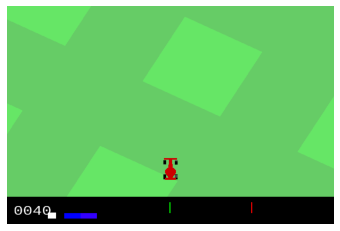

In [ ]:
frames = []
rewards = []

for _ in range(STARTUP_FRAMES):
  env.step([0, 0, 0])
  env.render()

for _ in range(timesteps):
  obs, reward, done, info = env.step(action)
  frames.append(env.render(mode='rgb_array'))
  rewards.append(reward)
  if done:
    break

plot_animation(frames)

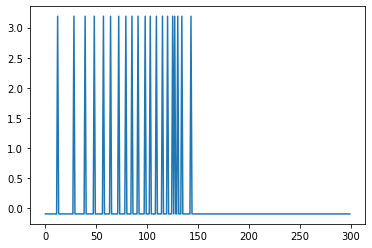

In [ ]:
plt.plot(rewards)

Now we plot the model's "dream" of the same episode.

In [ ]:
env = gym.make('CarRacing-v0')
env.reset()
action = [-0.01, 0.1, 0]
timesteps = 300

Track generation: 1306..1637 -> 331-tiles track


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
vae = build_vae()
rnn = MDNRNN()

In [ ]:
vae.model.load_weights(vae_weights_dir + 'weights.hdf5')

In [ ]:
rnn.model.load_weights(rnn_weights_dir + 'weights.hdf5')

In [ ]:
obs = env.reset()
frames = [obs]
cur_z = vae.encoder.predict(np.array([obs]))[0]

cur_h = np.zeros(shape=(RNN_HIDDEN_UNITS,))
cur_c = np.zeros(shape=(RNN_HIDDEN_UNITS,))
cur_reward = 1000

rnn_x = []

frames = []
rewards = []


for _ in range(timesteps):
  x = np.concatenate([cur_z, action, [cur_reward]], axis=0)
  rnn_input = [np.array([[x]]), np.array([cur_h]), np.array([cur_c])]
  out = rnn.forward_model.predict(rnn_input)

  y_pred = out[0][0][0]
  cur_h = out[1][0]
  cur_c = out[2][0]

  z_pred = y_pred[:(3 * Z_DIM * GAUSSIAN_MIXTURES)]
  cur_reward = adjust_reward(y_pred[-1])

  z_pred = np.reshape(z_pred, [-1, GAUSSIAN_MIXTURES * 3])
  rewards.append(rew_pred)

  mu, log_sigma = sample_mu_log_sigma(*get_mixture_coeff_np(z_pred))

  cur_z = mu + (np.exp(log_sigma) *  np.random.randn(*log_sigma.shape) * 0.5)

  obs = vae.decoder.predict(np.array([cur_z]))[0]
  frames.append(obs)

We see the model's "dream" of the track deviates from reality quite distinctly. But, some important points were captured: for example the model was able to tell that the car should be turning left.

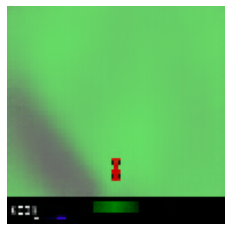

In [ ]:
plot_animation(frames)

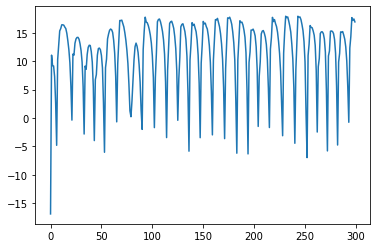

In [ ]:
plt.plot(rewards)

## The Controller

Since Colab kernels only have one CPU core, this version of the code will not use the parallelism used in the book.

Below is a class which contains code for the controller.

In [9]:
def controller_activations(x):
  """Activation functions for the output of the controller."""
  x = np.tanh(x)
  # The 2nd and 3rd output need to be in [0, 1].
  x[1] = (x[1] + 1) / 2
  x[2] = (x[2] + 1) / 2
  return x


class Controller(object):
  """Controller implementation from the book."""

  def __init__(self, output_size=3):
    self.weight = []
    self.bias = []
    self.param_count = 0
    self.shapes = [(RNN_HIDDEN_UNITS + Z_DIM, output_size)]

    for shape in self.shapes:
      self.weight.append(np.zeros(shape))
      self.bias.append(np.zeros(shape[1]))
      self.param_count += np.product(shape) + shape[1]

  def predict_action(self, x, t=0):
    """Get the next predicted action from the input x."""
    h = np.array(x).flatten()
    for w, b in zip(self.weight, self.bias):
      h = controller_activations(np.matmul(h, w) + b)
    return h

  def random_model_params(self, stddev=0.1):
    """Get randomly initialized model parameters."""
    return np.random.randn(self.param_count) * stddev

  def set_model_params(self, params):
    """Update model parameters."""
    ptr = 0
    for i, shape in enumerate(self.shapes):
      s_w = np.product(shape)  # N params in weights.
      s_b = shape[1]  # N params in bias term.
      s = s_w + s_b
      chunk = params[ptr:(ptr + s)]
      self.weight[i] = chunk[:s_w].reshape(shape)
      self.bias[i] = chunk[s_w:].reshape(shape[1])
      ptr += s

  def load_params(self, fname):
    """Load the controller params."""
    with open(fname) as f:
      data = json.load(f)
    params = np.array(data[0])
    self.set_model_params(params)


class RLModel(object):
  """Reinforcment learning model which will train an agent for CarRacing-v0."""

  def __init__(self, vae, rnn, controller):
    self.vae = vae
    self.rnn = rnn
    self.controller = controller
    self.h = np.zeros((RNN_HIDDEN_UNITS,))
    self.c = np.zeros((RNN_HIDDEN_UNITS,))

  def reset(self):
    """Clears the model's RNN state."""
    self.h = np.zeros((RNN_HIDDEN_UNITS,))
    self.c = np.zeros((RNN_HIDDEN_UNITS,))

  def predict_action(self, obs, action, reward):
    """Predict the next action, also updates the RNN state."""
    if obs.shape == self.vae.input_shape:
      obs = scale_observation(obs)
      obs = self.vae.encoder.predict(np.array([obs]))[0]
    rnn_in = [np.array([[np.concatenate([obs, action, [reward]])]]),
              np.array([self.h]), np.array([self.c])]
    out = self.rnn.forward_model.predict(rnn_in)
    self.h = out[1][0]
    self.c = out[2][0]
    return self.controller.predict_action(np.concatenate([obs, self.h]))


def build_model():
  """Returns a new instance of the RLModel."""
  vae = build_vae()
  vae.model.load_weights(vae_weights_dir + 'weights.hdf5')
  rnn = MDNRNN()
  rnn.model.load_weights(rnn_weights_dir + 'weights.hdf5')
  controller = Controller()
  return RLModel(vae, rnn, controller)

Next, we will define a class which implements our model's "dream" of the `CarRacing-v0` environment as an OpenAI Gym. This will let us write reuseable code that can train the controller in the real or dream `CarRacing-v0` environment.

In [10]:
initial_z = np.load(os.path.join(base_dir, 'initial_z.npz'))
initial_mus = initial_z['initial_mus']
initial_log_vars = initial_z['initial_log_vars']
initial_mu_log_vars = [list(el) for el in zip(initial_mus, initial_log_vars)]

In [11]:
class CarRacingDream(object):
  """Custom car racing dream environment. Implements OpenAI Gym env."""

  def __init__(self, model):
    assert model is not None
    self.model = model

    self.observation_space = Box(low=-50.0, high=50.0, shape=(Z_DIM,),
                                 dtype=np.float32)
    self.action_space = Box(np.array([-1, 0, 0]), np.array([1, 1, 1]),
                            dtype=np.float32)
    self.np_random = None
    self.seed()

    self.t = None
    self.z = None
    self.h = None
    self.c = None
    self.previous_reward = None
    self.reset()

  def seed(self, seed=None):
    """Set the random seed."""
    self.np_random, seed = seeding.np_random(seed)
    return [seed]

  def reset(self):
    """Reset the environment."""
    idx = self.np_random.randint(0, len(initial_mu_log_vars))
    init_mu, init_log_var = initial_mu_log_vars[idx]
    init_log_sigma = init_log_var / 2.0
    self.z = self.sample_z(init_mu, init_log_sigma)
    self.h = np.zeros(RNN_HIDDEN_UNITS)
    self.c = np.zeros(RNN_HIDDEN_UNITS)
    self.previous_reward = 0
    self.t = 0
    return self.z

  def sample_z(self, mu, log_sigma):
    """Sample a random variable from the distribution learned by the VAE."""
    return mu + (np.exp(log_sigma) * self.np_random.randn(*log_sigma.shape))

  def step(self, action):
    """Process an action provided by the RL agent."""
    self.t += 1
    z, reward = self.sample_mdn_output(action)
    next_done = self.t > 1000
    return z, reward, next_done, {}

  def sample_mdn_output(self, action):
    """Sample the next MDN output and update internal state."""
    x = np.concatenate([self.z, action, [self.previous_reward]], axis=0)
    rnn_input = [np.array([[x]]), np.array([self.h]), np.array([self.c])]
    out = self.model.rnn.forward_model.predict(rnn_input)

    y_pred = out[0][0][0]
    new_h = out[1][0]
    new_c = out[2][0]

    mdn_pred = y_pred[:(3 * Z_DIM * GAUSSIAN_MIXTURES)]
    mdn_pred = np.reshape(mdn_pred, [-1, GAUSSIAN_MIXTURES * 3])
    new_reward = adjust_reward(y_pred[-1])

    mu, log_sigma = sample_mu_log_sigma(*get_mixture_coeff_np(mdn_pred))
    new_z = self.sample_z(mu, log_sigma)

    self.h = new_h
    self.c = new_c
    self.z = new_z
    self.previous_reward = new_reward
    return new_z, new_reward

  def render(self, mode='rgb_array'):
    """Render the environment using the VAE decoder."""
    return self.model.vae.decoder.predict(np.array([self.z]))[0]

  def close(self):
    """Does nothing, but needed for implementing an OpenAI Gym env."""
    pass


def build_env(name, seed=-1, model=None):
  """Create the environment for the RL agent."""
  if name == 'car_racing':
    env = gym.make('CarRacing-v0')
  elif name == 'car_racing_dream':
    env = CarRacingDream(model)
  else:
    raise Exception('could not find env with name: {}'.format(name))
  if seed >= 0:
    env.seed(seed)
  return env

Now we will add code which has the model play the game in either of the environments. The function will return the rewards from each episode and how many timesteps each episode lasted.


In [12]:
def simulate(model, env, n_episodes=5, seed=-1, max_episode_length=1000):
  """Have the agent play several episodes in the provided environment."""
  if seed >= 0:
    random.seed(seed)
    np.random.seed(seed)
    env.seed(seed)
  
  rewards = []

  for _ in range(n_episodes):
    model.reset()
    obs = env.reset()
    reward = 0
    action = np.array([0, 0, 0])    
    total_reward = 0

    for t in range(max_episode_length):
      if obs.shape == model.vae.input_shape:  # Running in the real environment
        reward = adjust_reward(reward)
      action = model.predict_action(obs, action, reward)
      obs, reward, done, info = env.step(action)
      total_reward += reward
      if done:
        break
    
    rewards.append(total_reward)
    env.close()

  return rewards

### CMA-ES

Below is an implementation of the Covariance Matrix Adaptation Evolution Strategy (CMA-ES) algorithm based on the library `cma` and the code from the book.

In [13]:
class CMAES(object):
  """Container class for cma's CMA-ES implementation."""

  def __init__(self, n_params, sigma_init=0.10, popsize=256, weight_decay=0.01):
    self.es = cma.CMAEvolutionStrategy([0] * n_params, sigma_init,
                                       {'popsize': popsize})
    self.solutions = None
    self.weight_decay = weight_decay
    self.popsize = popsize

  def ask(self):
    """Returns a list of parameters."""
    self.solutions = np.array(self.es.ask())
    return self.solutions

  def compute_weight_decay(self):
    """Compute the weight decay term."""
    return -self.weight_decay * np.mean(self.solutions ** 2, axis=1)

  def tell(self, rewards):
    """Iterate the evolution after getting results."""
    rewards = -np.array(rewards)  # Negative because we want to maximize reward
    if self.weight_decay > 0:
      rewards += self.compute_weight_decay()
    self.es.tell(self.solutions, rewards.tolist())

  def current_param(self):
    """Current mean solution."""
    return self.es.result[5]

  def best_param(self):
    """Best solution."""
    return self.es.result[0]
    
  def result(self):
    """Returns (best params, best reward, current std dev)."""
    r = self.es.result
    return (r[0], -r[1], r[6])

Below is the definition for the training loop for the controller. One advantage of doing away with the parallelism in the book is that the code is much simpler, but the downside is it takes much more time to run!

In [14]:
PRECISION = 10000

In [15]:
class Seeder(object):
  """Generates random seeds for training."""
  
  def __init__(self, init_seed=111):
    np.random.seed(init_seed)
    self.limit = np.int32((2 ** 31) - 1)

  def next_batch(self, batch_size):
    """Get the random seeds for the next batch."""
    return np.random.randint(self.limit, size=batch_size).tolist()


def train_controller(model, env, n_generations, checkpoint_dir,
                     initial_generation=0):
  """Training loop for the controller model."""
  seeder = Seeder()

  if initial_generation > 0:
    with open(os.path.join(
        checkpoint_dir, 'es-{}.pk'.format(initial_generation)), 'rb') as f:
      es = pickle.load(f)
  else:
    es = CMAES(model.controller.param_count)

  for t in range(initial_generation + 1, n_generations + 1):
    print('Generation:\t', t)
    solutions = es.ask()
    seeds = seeder.next_batch(es.popsize)

    rewards = []
    i = 0
    for seed, solution in zip(seeds, solutions):
      i += 1
      print('\rUsing parameters {}/{}'.format(i, es.popsize), end='',
            flush=True)
      model.controller.set_model_params(solution)
      attempt_rewards = simulate(model, env, seed=seed)
      reward = np.mean(attempt_rewards)
      rewards.append(reward)

    print('Mean reward:\t', np.mean(rewards))
    es.tell(rewards)

    for fname in ['weights.json', 'weights-{}.json'.format(t)]:
      with open(os.path.join(checkpoint_dir, fname), 'w+') as out:
        json.dump([np.array(es.current_param()).round(4).tolist()], out,
                  sort_keys=True, indent=2, separators=(',', ': '))
        
    with open(os.path.join(checkpoint_dir, 'es-{}.pk'.format(t)), 'wb') as f:
      pickle.dump(es, f)

Now let's train the controller in the dream environment for 10 generations of CMA-ES.

In [ ]:
model = build_model()
env = build_env('car_racing_dream', model=model)

In [ ]:
train_controller(model, env, n_generations=10,
                 checkpoint_dir=controller_weights_dir,
                 initial_generation=0)

Now we will have the agent run in the real environment after learning from the dream environment.

In [ ]:
model = build_model()
model.controller.load_params(
    os.path.join(controller_weights_dir, 'weights.json'))

In [ ]:
env = build_env('car_racing')

In [21]:
frames = []
obs = env.reset()
action = np.array([0, 0, 0])
reward = 0

while True:
  action = model.predict_action(obs, action, reward)
  obs, reward, done, info = env.step(action)
  reward = adjust_reward(reward)
  frames.append(env.render(mode='rgb_array'))
  if done:
    break

Track generation: 1249..1565 -> 316-tiles track


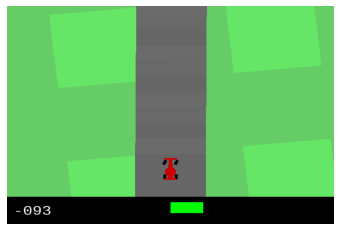

In [23]:
plot_animation(frames)